<a href="https://colab.research.google.com/github/DilemmaFixer3/AI_pr_5-6-7/blob/main/lab13_var1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Встановлення необхідних бібліотек (TensorFlow/Keras для Autoencoder)
!pip install scikit-learn tensorflow pandas numpy matplotlib

/tmp/ipython-input-3549271278.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.to_datetime(pd.date_range(start='2024-01-01', periods=n_samples, freq='H'))


Перші 5 записів даних:
                     Consumption
2024-01-01 00:00:00    20.496714
2024-01-01 01:00:00    19.961734
2024-01-01 02:00:00    20.847675
2024-01-01 03:00:00    21.822985
2024-01-01 04:00:00    20.165740


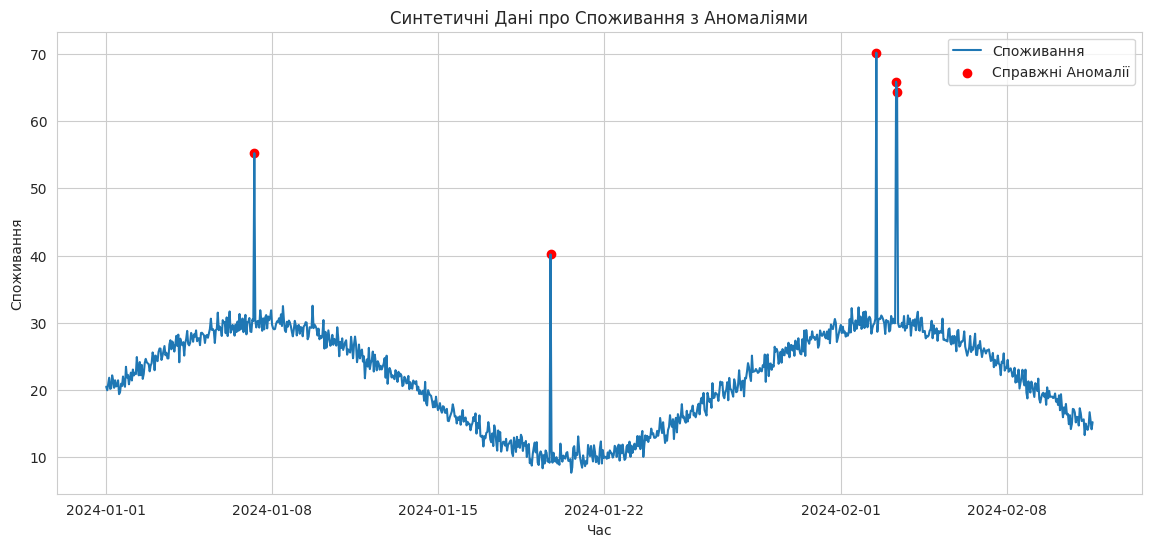


Кількість аномалій, виявлених Isolation Forest: 10


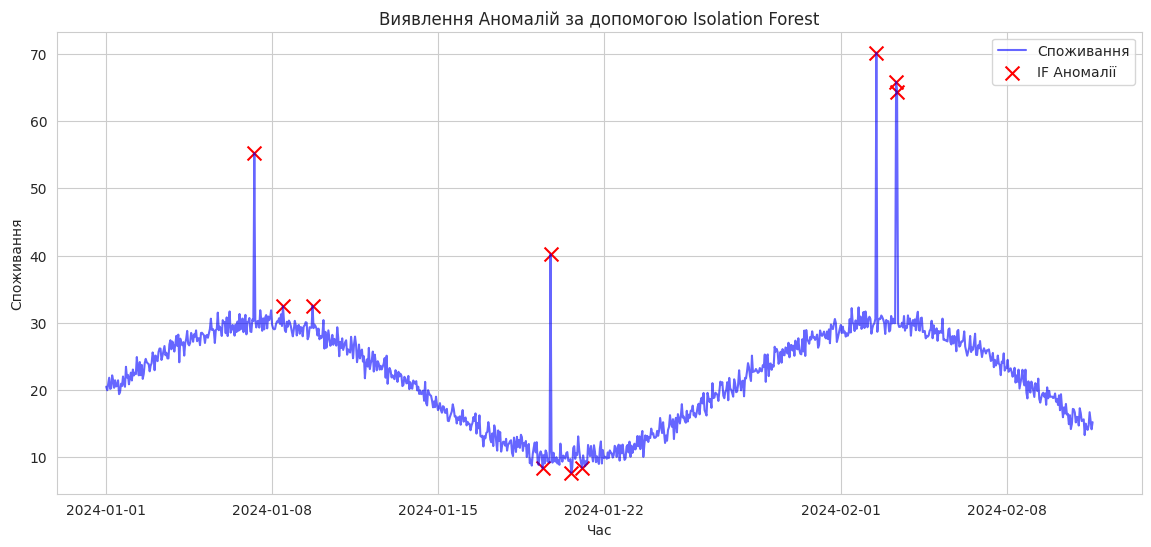

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Порогова помилка реконструкції (95-й перцентиль): 2.8288
Кількість аномалій, виявлених Autoencoder: 50


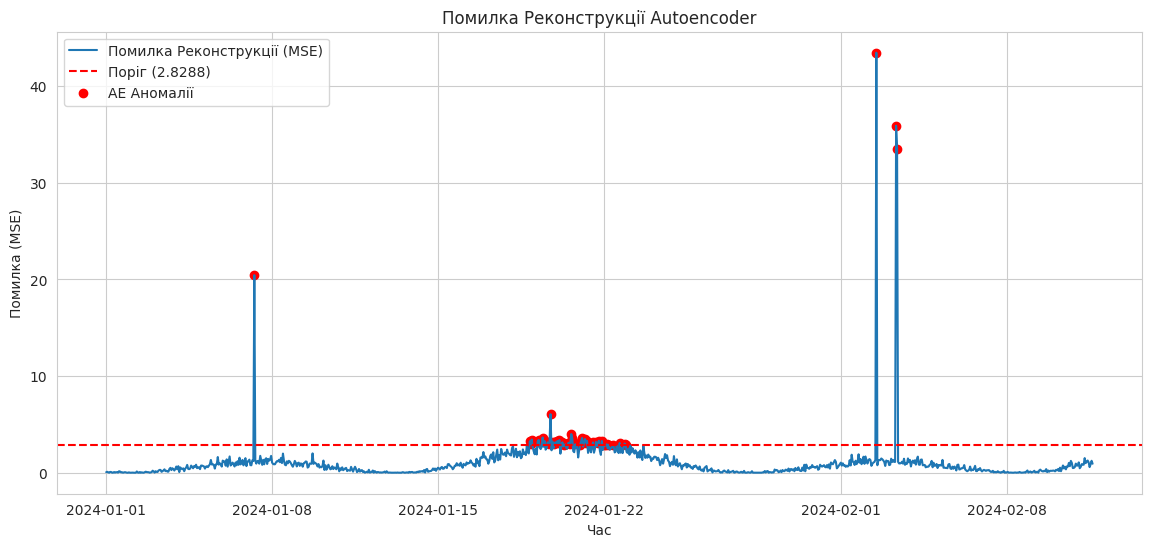


Кількість аномалій, виявлених обома методами: 8

--- СИСТЕМА СПОВІЩЕНЬ ---
 СПОВІЩЕННЯ ПРО АНОМАЛІЮ: 2024-01-07 06:00:00!
   Виявлено аномальне споживання: 55.23 одиниць.
   Рекомендовано перевірити обладнання/систему.
------------------------------
 СПОВІЩЕННЯ ПРО АНОМАЛІЮ: 2024-01-19 10:00:00!
   Виявлено аномальне споживання: 8.36 одиниць.
   Рекомендовано перевірити обладнання/систему.
------------------------------
 СПОВІЩЕННЯ ПРО АНОМАЛІЮ: 2024-01-19 18:00:00!
   Виявлено аномальне споживання: 40.16 одиниць.
   Рекомендовано перевірити обладнання/систему.
------------------------------
 СПОВІЩЕННЯ ПРО АНОМАЛІЮ: 2024-01-20 15:00:00!
   Виявлено аномальне споживання: 7.70 одиниць.
   Рекомендовано перевірити обладнання/систему.
------------------------------
 СПОВІЩЕННЯ ПРО АНОМАЛІЮ: 2024-01-21 02:00:00!
   Виявлено аномальне споживання: 8.45 одиниць.
   Рекомендовано перевірити обладнання/систему.
------------------------------
 СПОВІЩЕННЯ ПРО АНОМАЛІЮ: 2024-02-02 12:00:00!
   Ви

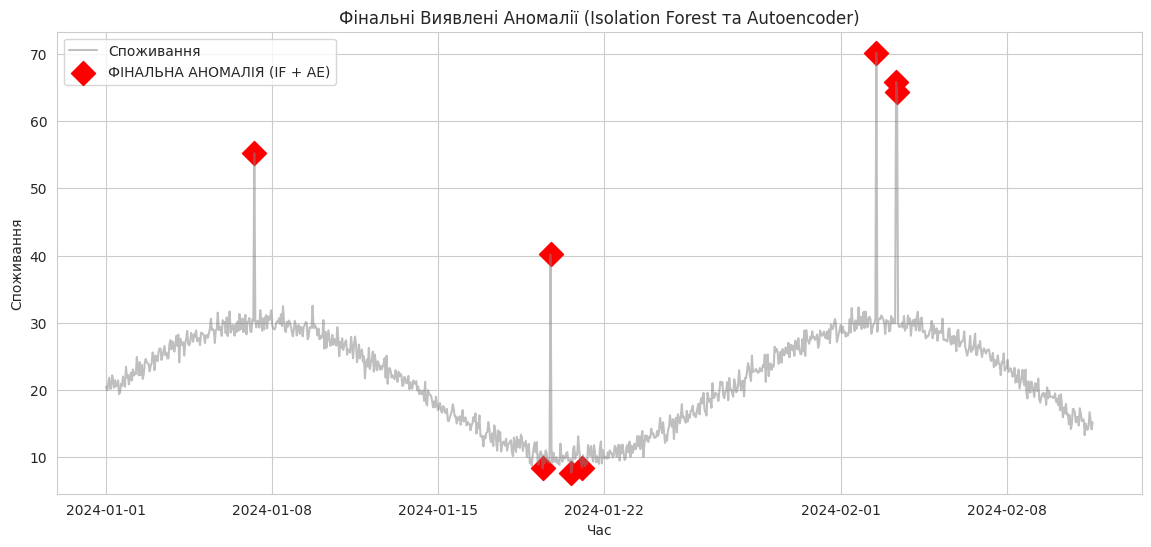

In [2]:


# Імпорт
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models

# Налаштування стилю графіків
sns.set_style("whitegrid")

## Генерація Синтетичних Даних
np.random.seed(42)
n_samples = 1000
time_index = pd.to_datetime(pd.date_range(start='2024-01-01', periods=n_samples, freq='H'))

# Нормальне споживання: синусоїда + випадковий шум
normal_consumption = (np.sin(np.arange(n_samples) / 100) * 10 + 20) + np.random.normal(0, 1, n_samples)
df = pd.DataFrame({'Consumption': normal_consumption}, index=time_index)

# Додавання Аномалій (різкі стрибки)
anomaly_indices = [150, 450, 780, 800, 801]
df.loc[df.index[anomaly_indices], 'Consumption'] += [25, 30, 40, 35, 35]

print("Перші 5 записів даних:")
print(df.head())

## Візуалізація даних
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Consumption'], label='Споживання')
plt.scatter(df.index[anomaly_indices], df['Consumption'].iloc[anomaly_indices], color='red', label='Справжні Аномалії', marker='o')
plt.title('Синтетичні Дані про Споживання з Аномаліями')
plt.xlabel('Час')
plt.ylabel('Споживання')
plt.legend()
plt.show()

# Масштабування даних (важливо для нейромереж, корисно для Isolation Forest)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Consumption']])

## Навчання Isolation Forest
# contamination: очікувана частка аномалій (наприклад, 1%)
clf_if = IsolationForest(random_state=42, contamination=0.01)
clf_if.fit(X_scaled)

# Прогнозування аномалій:
# -1 = Аномалія, 1 = Норма
df['IF_Anomaly'] = clf_if.predict(X_scaled)
df['IF_Score'] = clf_if.decision_function(X_scaled)

# Виділення виявлених аномалій
if_anomalies = df[df['IF_Anomaly'] == -1]

print(f"\nКількість аномалій, виявлених Isolation Forest: {len(if_anomalies)}")

## Візуалізація результатів Isolation Forest
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Consumption'], label='Споживання', color='blue', alpha=0.6)
plt.scatter(if_anomalies.index, if_anomalies['Consumption'], color='red', label='IF Аномалії', marker='x', s=100)
plt.title('Виявлення Аномалій за допомогою Isolation Forest')
plt.xlabel('Час')
plt.ylabel('Споживання')
plt.legend()
plt.show()


## Навчання Autoencoder
# Створення моделі: Енкодер -> Латентний простір -> Декодер
input_dim = X_scaled.shape[1]
encoding_dim = 1 # Розмір латентного простору (стиснуте представлення)

autoencoder = models.Sequential([
    # Енкодер
    layers.Dense(8, activation='relu', input_shape=(input_dim,)),
    layers.Dense(4, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'), # Латентний простір (Bottleneck)

    # Декодер
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse') # mse = Mean Squared Error

# Навчання (тільки на нормальних даних)
# Оскільки ми не знаємо, які точки є нормальними, ми навчаємо на всіх даних,
# але аномалії матимуть значно вищу помилку реконструкції.
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0, # Вимкнення детального виводу
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

## Прогнозування та розрахунок помилки реконструкції
X_pred = autoencoder.predict(X_scaled, verbose=0)
# Помилка реконструкції (Mean Squared Error)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)
df['AE_Error'] = mse

# Визначення порогу (наприклад, 95-й перцентиль помилок)
threshold_ae = np.quantile(df['AE_Error'], 0.95)
df['AE_Anomaly'] = (df['AE_Error'] > threshold_ae).astype(int)
ae_anomalies = df[df['AE_Anomaly'] == 1]

print(f"\nПорогова помилка реконструкції (95-й перцентиль): {threshold_ae:.4f}")
print(f"Кількість аномалій, виявлених Autoencoder: {len(ae_anomalies)}")

## Візуалізація результатів Autoencoder
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['AE_Error'], label='Помилка Реконструкції (MSE)')
plt.axhline(threshold_ae, color='red', linestyle='--', label=f'Поріг ({threshold_ae:.4f})')
plt.scatter(ae_anomalies.index, ae_anomalies['AE_Error'], color='red', label='AE Аномалії', marker='o')
plt.title('Помилка Реконструкції Autoencoder')
plt.xlabel('Час')
plt.ylabel('Помилка (MSE)')
plt.legend()
plt.show()

## Комбінований Аналіз
# Isolation Forest: -1 (аномалія), 1 (норма)
# Autoencoder: 1 (аномалія), 0 (норма)
# Комбінована Аномалія = Аномалія IF * Аномалія AE
df['Combined_Anomaly'] = np.where(
    (df['IF_Anomaly'] == -1) & (df['AE_Anomaly'] == 1),
    1,
    0
)

final_anomalies = df[df['Combined_Anomaly'] == 1]

print(f"\nКількість аномалій, виявлених обома методами: {len(final_anomalies)}")

## Розробка Системи Сповіщень
def send_alert(data_point):
    """Імітація відправки сповіщення."""
    timestamp = data_point.name
    consumption = data_point['Consumption']
    print(f" СПОВІЩЕННЯ ПРО АНОМАЛІЮ: {timestamp}!")
    print(f"   Виявлено аномальне споживання: {consumption:.2f} одиниць.")
    print("   Рекомендовано перевірити обладнання/систему.")
    print("-" * 30)

# Ітерація та Сповіщення
print("\n--- СИСТЕМА СПОВІЩЕНЬ ---")
if len(final_anomalies) > 0:
    for index, row in final_anomalies.iterrows():
        send_alert(row)
else:
    print(" Аномалій, підтверджених обома моделями, не виявлено.")

## Фінальна Візуалізація
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Consumption'], label='Споживання', color='gray', alpha=0.5)
plt.scatter(final_anomalies.index, final_anomalies['Consumption'], color='red',
            label='ФІНАЛЬНА АНОМАЛІЯ (IF + AE)', marker='D', s=150)
plt.title('Фінальні Виявлені Аномалії (Isolation Forest та Autoencoder)')
plt.xlabel('Час')
plt.ylabel('Споживання')
plt.legend()
plt.show()